<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/regression/backward_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
!git clone https://github.com/pharringtonp19/business-analytics.git

fatal: destination path 'business-analytics' already exists and is not an empty directory.


### **Import Packages**

In [143]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import jax.numpy as jnp
import jax
import seaborn as sb
from functools import partial

### **Specify Dataset**

In [144]:
dataset = 'brookline'

### **Read In Data Set**

In [145]:
if dataset == 'brookline':
  df = pd.read_csv('/content/business-analytics/datasets/brookline.csv')
else:
  df = pd.read_csv('/content/business-analytics/datasets/CASchools.csv')
  df['Students_per_Teacher'] = df['students'] / df['teachers']
df.head()

,price,stNumber,stName,size,beacon,baseFloor,buildingStyle,elevators,rooms,bedrooms,fullBathrooms,halfBathrooms,garage
0,174000,150,PLEASANT ST,1060,0,4,MID-RISE,1,4,2,1,1,1.0
1,337000,7,LEVERETT ST,831,0,1,DECKER,0,4,2,1,0,0.0
2,850000,24,EUSTON ST,2246,0,1,ROW-END,0,10,6,3,0,0.0
3,516000,417,WASHINGTON ST,1574,0,2,LOW-RISE,0,6,3,2,0,0.0
4,145000,150,PLEASANT ST,669,0,4,MID-RISE,1,3,1,1,0,1.0


### **Create Function**

In [146]:
def get_pvalues(reg_formula):
  linear_model  = smf.ols(reg_formula, df)
  results = linear_model.fit()
  pvalues = results.pvalues
  p_df = pd.DataFrame(list(pvalues.items()), columns=['variable', 'pvalue'])
  p_df = p_df[p_df['variable'] != 'Intercept']
  p_df['base_variable'] = p_df['variable'].apply(lambda x: x.split('[')[0] if 'C(' in x else x)
  row = p_df.groupby('base_variable')['pvalue'].min().sort_values(ascending=False).head(1)
  return row.index[0], row.values[0]

if dataset == 'brookline':
  print(get_pvalues('price ~ beacon'))
else:
  print(get_pvalues('math ~ expenditure'))

('beacon', 0.0689400325872895)


### **Store Results**

In [147]:
# To Keep Track of Results
ordered_variables = []
pvalues = []

### **Specify the dependent variable**

In [148]:
dep_var = 'price' if dataset == 'brookline' else 'math'

### **Create list of possible Right Hand Side Variables**

In [149]:
if dataset == 'brookline':
  eligible_vars = df.columns.drop(['stNumber', 'stName', dep_var]).tolist()
  categorical_vars = ['buildingStyle']
else:
  eligible_vars = df.columns.drop(['Unnamed: 0', 'district', 'school', 'county', 'grades', dep_var]).tolist()

### **Create Dictionary of Variable Name and Regression String Format**

In [150]:
eligible_vars = {key: key if key not in categorical_vars else f'C({key})' for key in eligible_vars}
inverted_vars = {value: key for key, value in eligible_vars.items()}

### **For Loop**

In [151]:
for i in range(len(eligible_vars)):

  # Create Regression Formula
  reg_formula = dep_var + ' ~ ' + ' + '.join(list(eligible_vars.values()))

  # Get Variable String and Pvalue of Highest Pvalue
  var_string, pvalue = get_pvalues(reg_formula)

  # Get Corresponding Variable
  key = inverted_vars[var_string]

  ordered_variables.append(key)

  pvalues.append(pvalue)
  del eligible_vars[key]

### **Plot**

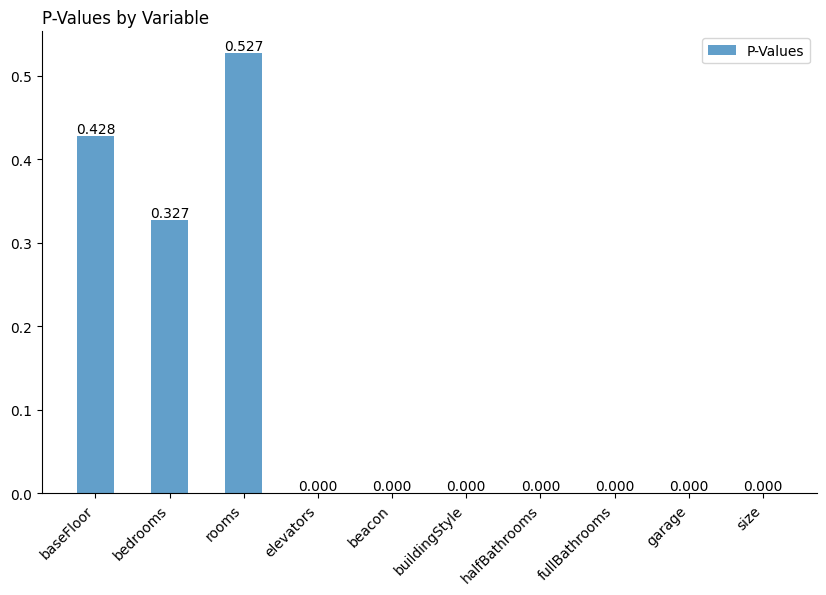

In [157]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of the bars and their positions
bar_width = 0.5
x = np.arange(len(ordered_variables))

# Plot the p-values as bars
bars = ax.bar(ordered_variables, pvalues, width=bar_width, label="P-Values", alpha=0.7)

# Add labels, title, and angle the x-axis labels
ax.set_title("P-Values by Variable", loc='left')
ax.set_xticks(x)
ax.set_xticklabels(ordered_variables, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Display values above each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

plt.show()